<a href="https://colab.research.google.com/github/marissa-graham/multiagent_systems/blob/master/Lab_2_(Evolutionary_Games).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import seaborn
import numpy as np
import pylab
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from collections import defaultdict

# Set up payoff matrices 

Names of games are PD, BS, and SH, and they are dictionaries. Keys are 'CC', 'CD', 'DC', 'DD' (payoff tuples for action pairs), 'name', 'symmetric', 'p1_0.95', 'p1_0.99', 'p2_0.95', 'p2_0.99' (payoff matrices for each player for each gamma).

## Define get_payoff_matrix function

In [0]:
def get_payoff_matrix(P, g):
    """
    P is a dictionary with action pairs as keys, and their corresponding
    payoff tuples as values. g is the future discounting factor.
    
    Prisoner's Dilemma: P = {'CC':(3,3), 'CD':(1,5), 'DC':(5,1), 'DD':(2,2)}
    Stag Hunt: P = {'CC':(4,4), 'CD':(0,3), 'DC':(3,0), 'DD':(3,3)}
    Battle of the Sexes: P = {'CC':(2,1), 'CD':(0,0), 'DC':(0,0), 'DD':(1,2)}
    
    Agent types: [AC, AD, TfT, !TfT]
    
    P[i,j] represents the payoff for an agent of type i playing against an 
    agent of type j. The zero index is a null agent, which makes lattice
    updating easier.
    """
    payoffs = np.zeros((5,5,2))
    b1 = 1/(1-g)
    b2 = 1/(1-g**2)
    b4 = 1/(1-g**4)
    
    # Game sequence is always the same action pair (9/16 match pairs)
    all_cc = b1*P['CC'] # AC-AC or AC-TfT or TfT-AC or TfT-TfT
    all_cd = b1*P['CD'] # AC-AD or !AC-TfT
    all_dc = b1*P['DC'] # AD-AC or !TfT-AC
    all_dd = b1*P['DD'] # AD-AD
    
    # Game sequence is always the same after initial round (4/16 match pairs)
    dc_dd = P['DC'] + g*all_dd # AD-TfT
    dd_dc = P['DD'] + g*all_dc # AD-!TfT
    cd_dd = P['CD'] + g*all_dd # TfT-AD
    dd_cd = P['DD'] + g*all_cd # !TfT-AD
    
    # Game sequence is a cycle (3/16 match pairs)
    cddc_ = b4*(P['CD'] + g*P['DD'] + g**2*P['DC'] + g**3*P['CC']) # TfT-!TfT
    ddcc_ = b4*(P['DC'] + g*P['DD'] + g**2*P['CD'] + g**3*P['CC']) # !TfT-TfT
    dcdc_ = b2*(P['DD'] + g*P['CC']) # !TfT-!TfT
    
    payoffs[[1,1,2,3],[1,2,1,3]] = all_cc
    payoffs[[1,1],[2,4]] = all_cd
    payoffs[[2,4],[1,1]] = all_dc
    payoffs[2,2] = all_dd
    
    payoffs[2,3] = dc_dd
    payoffs[2,4] = dd_dc
    payoffs[3,2] = cd_dd
    payoffs[4,2] = dd_cd
    
    payoffs[3,4] = cddc_
    payoffs[4,3] = ddcc_
    payoffs[4,4] = dcdc_
    
    game['symmetric'] = (payoffs[:,:,0] == payoffs[:,:,1].T).all() 
    game['p1_'+str(g)] = payoffs[:,:,0]
    game['p2_'+str(g)] = payoffs[:,:,1]
    return payoffs

## Run get_payoff_matrix to set up the games

In [0]:
PD = {'CC':np.array([3.,3.]), 'CD':np.array([1.,5.]), 
     'DC':np.array([5.,1.]), 'DD':np.array([2.,2.]),
     'name':"Prisoner's Dilemma"}

SH = {'CC':np.array([4.,4.]), 'CD':np.array([0.,3.]), 
     'DC':np.array([3.,0.]), 'DD':np.array([3.,3.]),
     'name':'Stag Hunt'}

BS = {'CC':np.array([2.,1.]), 'CD':np.array([0.,0.]), 
     'DC':np.array([0.,0.]), 'DD':np.array([1.,2.]),
     'name':'Battle of the Sexes'}

for game in [PD, SH, BS]:
    for g in [0.7, 0.75, 0.8, 0.85, 0.9, 0.99, 0.95]:
        P = get_payoff_matrix(game, g)
        if g == 0.95:
            print('Agent 1 Payoff Matrix for', game['name'], 'g='+str(g)+':\n',
                np.round(P[:,:,0], 2), '\n')#\n', np.round(P[:,:,1],2), '\n')

Agent 1 Payoff Matrix for Prisoner's Dilemma g=0.95:
 [[  0.     0.     0.     0.     0.  ]
 [  0.    60.    20.     0.    20.  ]
 [  0.   100.    40.    43.    97.  ]
 [  0.     0.    39.    60.    53.83]
 [  0.   100.    21.    55.93  49.74]] 

Agent 1 Payoff Matrix for Stag Hunt g=0.95:
 [[ 0.    0.    0.    0.    0.  ]
 [ 0.   80.    0.    0.    0.  ]
 [ 0.   60.   60.   60.   60.  ]
 [ 0.    0.   57.   80.   48.45]
 [ 0.   60.    3.   50.03 69.74]] 

Agent 1 Payoff Matrix for Battle of the Sexes g=0.95:
 [[ 0.    0.    0.    0.    0.  ]
 [ 0.   40.    0.    0.    0.  ]
 [ 0.    0.   20.   19.    1.  ]
 [ 0.    0.   19.   40.   14.37]
 [ 0.    0.    1.   14.37 29.74]] 



# Setup code for random experiments

play_random(initial_population, gamma, game, display=False) plots the population curves over time if display==True, and returns the list of results as a (# of results until convergence) x 5 matrix.

Convergence is defined as when we see a state that's a duplicate of some previous state. Initial population should be np.array(\[0, # of AC, # of AD, # of TfT, # of ~TfT\]), game is PD, SH, or BS (variable names, not strings).

In [0]:
def update_random(p, payoffs):
    """
    Update the number of each type of agent in the population based on
    replicator dynamics with random pairing.
    
    p is a vector [# of AC, # of AD, # of TfT, # of !TfT]
    """
    
    theta = p/900.
    u = np.dot(payoffs, theta)
    return p + np.round(theta * (u - np.dot(theta, u)),0)

def play_random(initial_population, gamma, game, ax=None):
    
    assert initial_population[0] < 1 # Can't have a null agent for real
    
    p = initial_population
    ac, ad, tft, ntft = initial_population[1:]
    results = [p]
    results_set = {tuple(p)}
    payoffs = game['p1_'+str(gamma)]
    
    while True:
        p = update_random(p, payoffs)
        results.append(p)
        results_set.add(tuple(p))
        if len(results) > 1.2*len(results_set):
            break
    
    results = np.array(results)
        
    if ax:
        agent_types = ['AC','AD','TfT','~TfT']
        for i in range(4):
            ax.plot(np.arange(results.shape[0]), results[:,i+1], label=agent_types[i])
        ax.set_xlabel('Generation Number')
        ax.set_ylabel('Number of Each Agent Type')
        ax.set_title('Initial Pop. ('+str(ac)+', '+str(ad)+', '+str(tft)+', '+
                  str(ntft)+'), g='+str(gamma))#+' for the '+game['name'])
        #plt.title('Initial Population AC='+str(ac)+', AD='+str(ad)+', TfT='+
        #          str(tft)+', ~TfT='+str(ntft)+' with gamma='+str(gamma)+
        #         ' for the '+game['name'])
        ax.legend()
        #plt.show()
        
    return results

# Random experiments

## AC vs. AD

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


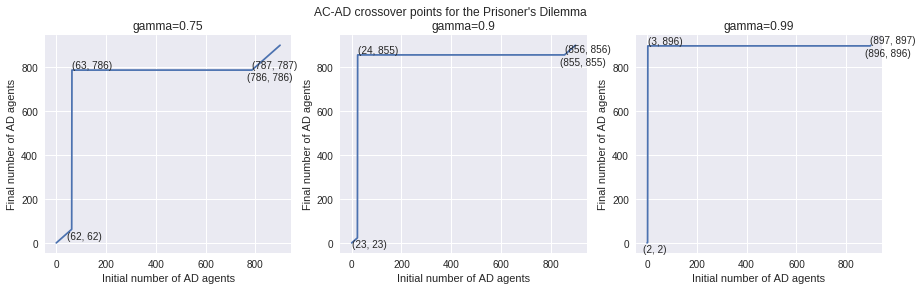

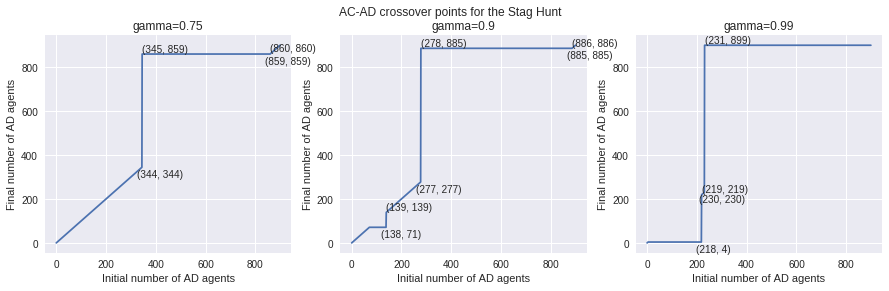

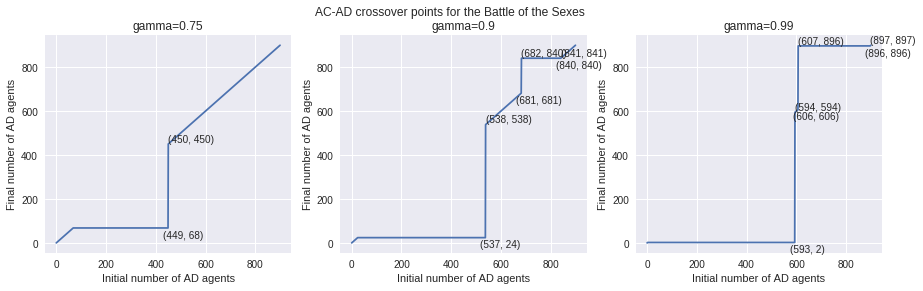

In [0]:
old_figsize = pylab.rcParams['figure.figsize']
pylab.rcParams['figure.figsize'] = (15,4)

for game in [PD, SH, BS]:
    i = 0
    fig, axes = plt.subplots(1,3)
    for gamma in [0.75, 0.9, 0.99]:
        
        final_states = defaultdict(set)
        final_num_AD = np.zeros(900)
        for n in range(900):
            results = play_random(np.array([0,900-n,n,0,0]), gamma, game)
            if results[0,1] != results[-1,1]:
                final_states[tuple(results[-1,:])].add(tuple(results[0,:]))
            final_num_AD[n] = results[-1,2]
        
        diffs2 = np.where(np.diff(np.diff(final_num_AD))>0)[0]
        for x in diffs2:
            xy = (x+1, int(final_num_AD[x+1]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(-5,-10), textcoords='offset points')
            xy = (x+2, int(final_num_AD[x+2]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(0,2), textcoords='offset points')
        """
        #print(final_states.keys())
        diffs = np.diff(final_num_AD)
        bigchange = np.where((diffs > 1) + (diffs < 0))[0]
        
        pylab.rcParams['figure.figsize'] = (12,6)
        
        for x in bigchange:
            fig1, axes1 = plt.subplots(1,2)
            play_random(np.array([0,900-x,x,0,0]), gamma, game, ax=axes1[0])
            play_random(np.array([0,900-x-1,x+1,0,0]), gamma, game, ax=axes1[1])
            fig1.suptitle("Dynamics of a game before and after sudden change")
            fig1.show()
            
        pylab.rcParams['figure.figsize'] = (20,5)
        """
        axes[i].plot(final_num_AD)
        axes[i].set_xlabel("Initial number of AD agents")
        axes[i].set_ylabel("Final number of AD agents")
        axes[i].set_title('gamma='+str(gamma))
        i += 1
    
    #fig.suptitle("Final number of AD agents vs. initial number of AD agents")
    fig.suptitle("AC-AD crossover points for the "+game['name'])
    fig.show()
    
pylab.rcParams['figure.figsize'] = old_figsize

## TfT vs. AD

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


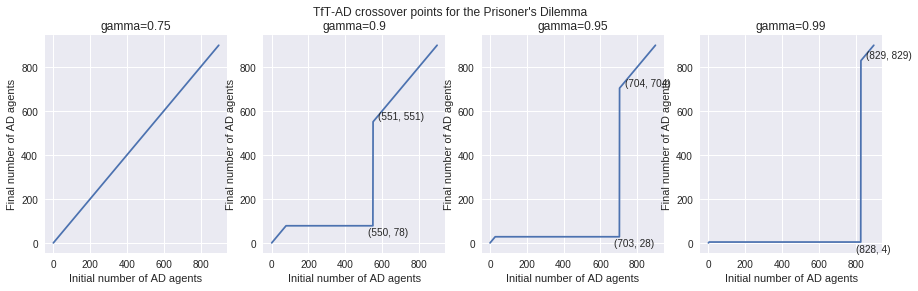

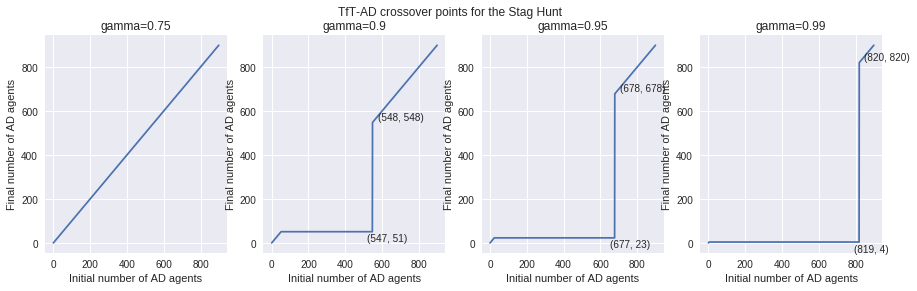

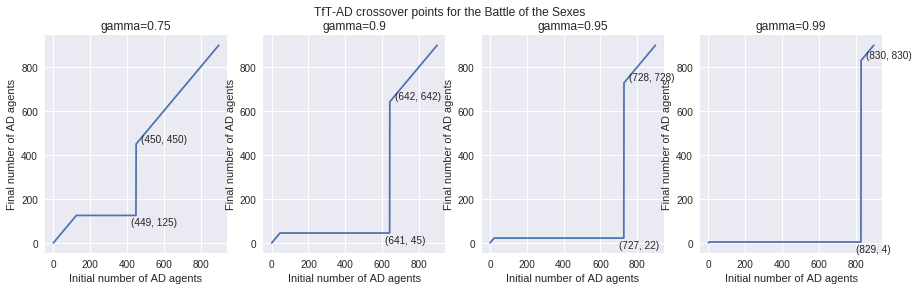

In [0]:
old_figsize = pylab.rcParams['figure.figsize']
pylab.rcParams['figure.figsize'] = (15,4)

for game in [PD, SH, BS]:
    i = 0
    fig, axes = plt.subplots(1,4)
    for gamma in [0.75, 0.9, 0.95, 0.99]:
        
        final_states = defaultdict(set)
        final_num_AD = np.zeros(900)
        for n in range(900):
            results = play_random(np.array([0,0,n,900-n,0]), gamma, game)
            if results[0,1] != results[-1,1]:
                final_states[tuple(results[-1,:])].add(tuple(results[0,:]))
            final_num_AD[n] = results[-1,2]
            
        diffs2 = np.where(np.diff(np.diff(final_num_AD))>0)[0]
        for x in diffs2:
            xy = (x+1, int(final_num_AD[x+1]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(-5,-10), textcoords='offset points')
            xy = (x+2, int(final_num_AD[x+2]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(5,2), textcoords='offset points')
        """
        #print(final_states.keys())
        diffs = np.diff(final_num_AD)
        bigchange = np.where((diffs > 1) + (diffs < 0))[0]
        
        pylab.rcParams['figure.figsize'] = (12,6)
        
        for x in bigchange:
            fig1, axes1 = plt.subplots(1,2)
            play_random(np.array([0,900-x,x,0,0]), gamma, game, ax=axes1[0])
            play_random(np.array([0,900-x-1,x+1,0,0]), gamma, game, ax=axes1[1])
            fig1.suptitle("Dynamics of a game before and after sudden change")
            fig1.show()
            
        pylab.rcParams['figure.figsize'] = (20,5)
        """
        axes[i].plot(final_num_AD)
        axes[i].set_xlabel("Initial number of AD agents")
        axes[i].set_ylabel("Final number of AD agents")
        axes[i].set_title('gamma='+str(gamma))
        i += 1
    
    #fig.suptitle("Final number of AD agents vs. initial number of AD agents")
    fig.suptitle("TfT-AD crossover points for the "+game['name'])
    fig.show()
    
pylab.rcParams['figure.figsize'] = old_figsize

## ~TfT vs AD

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


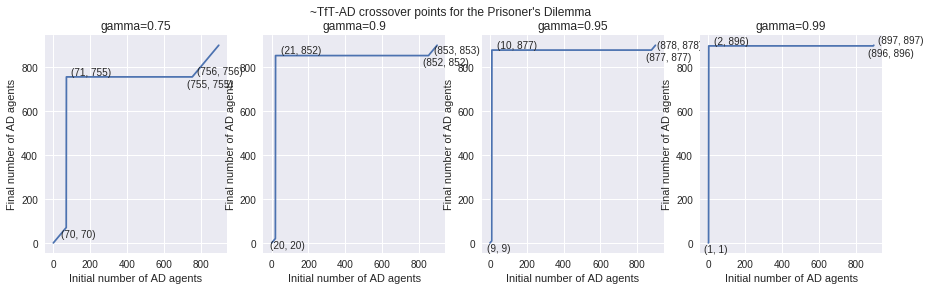

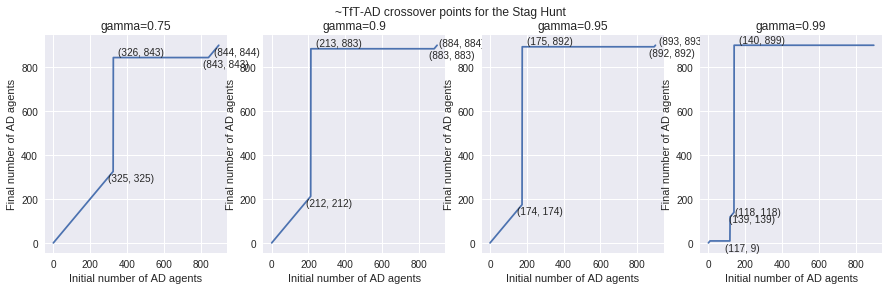

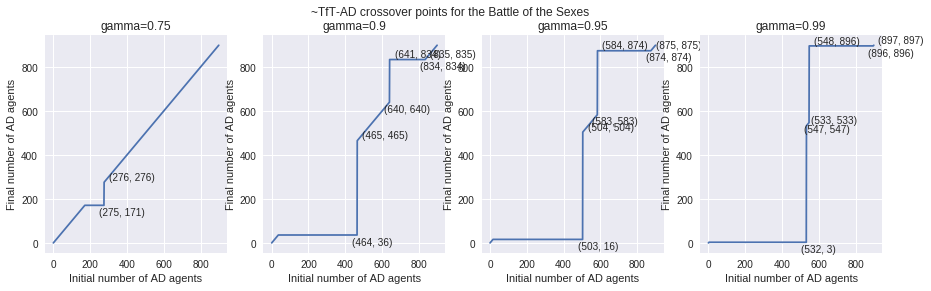

In [0]:
old_figsize = pylab.rcParams['figure.figsize']
pylab.rcParams['figure.figsize'] = (15,4)

for game in [PD, SH, BS]:
    i = 0
    fig, axes = plt.subplots(1,4)
    for gamma in [0.75, 0.9, 0.95, 0.99]:
        
        final_states = defaultdict(set)
        final_num_AD = np.zeros(900)
        for n in range(900):
            results = play_random(np.array([0,0,n,0,900-n]), gamma, game)
            if results[0,1] != results[-1,1]:
                final_states[tuple(results[-1,:])].add(tuple(results[0,:]))
            final_num_AD[n] = int(results[-1,2])
        
        #print(final_states.keys())
        diffs2 = np.where(np.diff(np.diff(final_num_AD))>0)[0]
        for x in diffs2:
            xy = (x+1, int(final_num_AD[x+1]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(-5,-10), textcoords='offset points')
            xy = (x+2, int(final_num_AD[x+2]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(5,2), textcoords='offset points')
                
        bigchange = np.where((diffs > 1) + (diffs < 0))[0]
        """
        pylab.rcParams['figure.figsize'] = (12,6)
        
        for x in bigchange:
            fig1, axes1 = plt.subplots(1,2)
            play_random(np.array([0,900-x,x,0,0]), gamma, game, ax=axes1[0])
            play_random(np.array([0,900-x-1,x+1,0,0]), gamma, game, ax=axes1[1])
            fig1.suptitle("Dynamics of a game before and after sudden change")
            fig1.show()
            
        pylab.rcParams['figure.figsize'] = (20,5)
        """
        
            
        axes[i].plot(final_num_AD)
        axes[i].set_xlabel("Initial number of AD agents")
        axes[i].set_ylabel("Final number of AD agents")
        axes[i].set_title('gamma='+str(gamma))
        i += 1
    
    fig.suptitle("~TfT-AD crossover points for the "+game['name'])
    fig.show()
    
pylab.rcParams['figure.figsize'] = old_figsize

## TfT vs. ~TfT

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


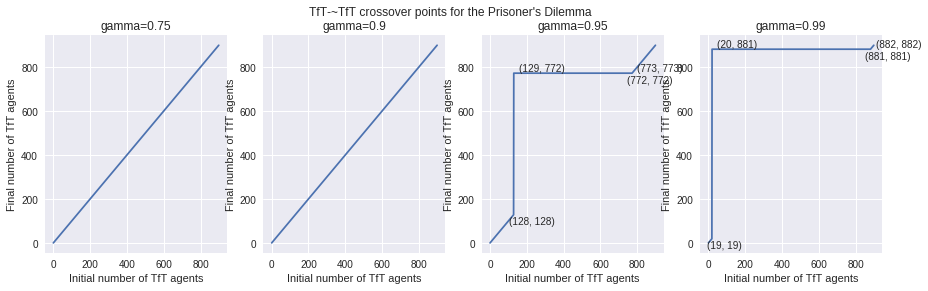

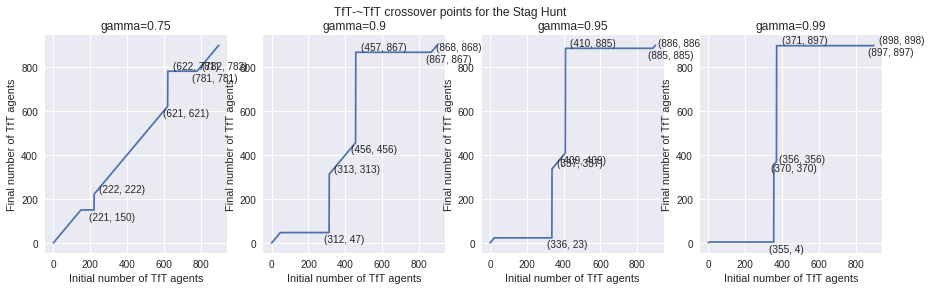

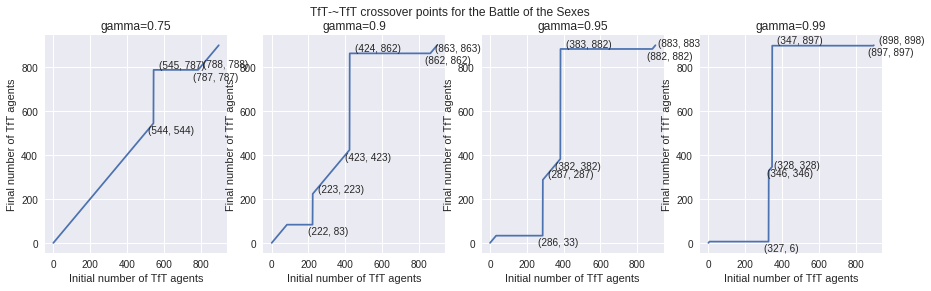

In [0]:
old_figsize = pylab.rcParams['figure.figsize']
pylab.rcParams['figure.figsize'] = (15,4)

for game in [PD, SH, BS]:
    i = 0
    fig, axes = plt.subplots(1,4)
    for gamma in [0.75, 0.9, 0.95, 0.99]:
        
        final_states = defaultdict(set)
        final_num_TfT = np.zeros(900)
        for n in range(900):
            results = play_random(np.array([0,0,0,n,900-n]), gamma, game)
            if results[0,3] != results[-1,3]:
                final_states[tuple(results[-1,:])].add(tuple(results[0,:]))
            final_num_TfT[n] = results[-1,3]
            
        diffs2 = np.where(np.diff(np.diff(final_num_TfT))>0)[0]
        for x in diffs2:
            xy = (x+1, int(final_num_TfT[x+1]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(-5,-10), textcoords='offset points')
            xy = (x+2, int(final_num_TfT[x+2]))
            axes[i].annotate('(%s, %s)' %xy, xy=xy, xycoords='data', 
                             xytext=(5,2), textcoords='offset points')
        """
        #print(final_states.keys())
        diffs = np.diff(final_num_AD)
        bigchange = np.where((diffs > 1) + (diffs < 0))[0]
        
        pylab.rcParams['figure.figsize'] = (12,6)
        
        for x in bigchange:
            fig1, axes1 = plt.subplots(1,2)
            play_random(np.array([0,900-x,x,0,0]), gamma, game, ax=axes1[0])
            play_random(np.array([0,900-x-1,x+1,0,0]), gamma, game, ax=axes1[1])
            fig1.suptitle("Dynamics of a game before and after sudden change")
            fig1.show()
            
        pylab.rcParams['figure.figsize'] = (20,5)
        """
        axes[i].plot(final_num_TfT)
        axes[i].set_xlabel("Initial number of TfT agents")
        axes[i].set_ylabel("Final number of TfT agents")
        axes[i].set_title('gamma='+str(gamma))
        i += 1
    
    #fig.suptitle("Final number of AD agents vs. initial number of AD agents")
    fig.suptitle("TfT-~TfT crossover points for the "+game['name'])
    fig.show()
    
pylab.rcParams['figure.figsize'] = old_figsize

## Look at random initializations

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


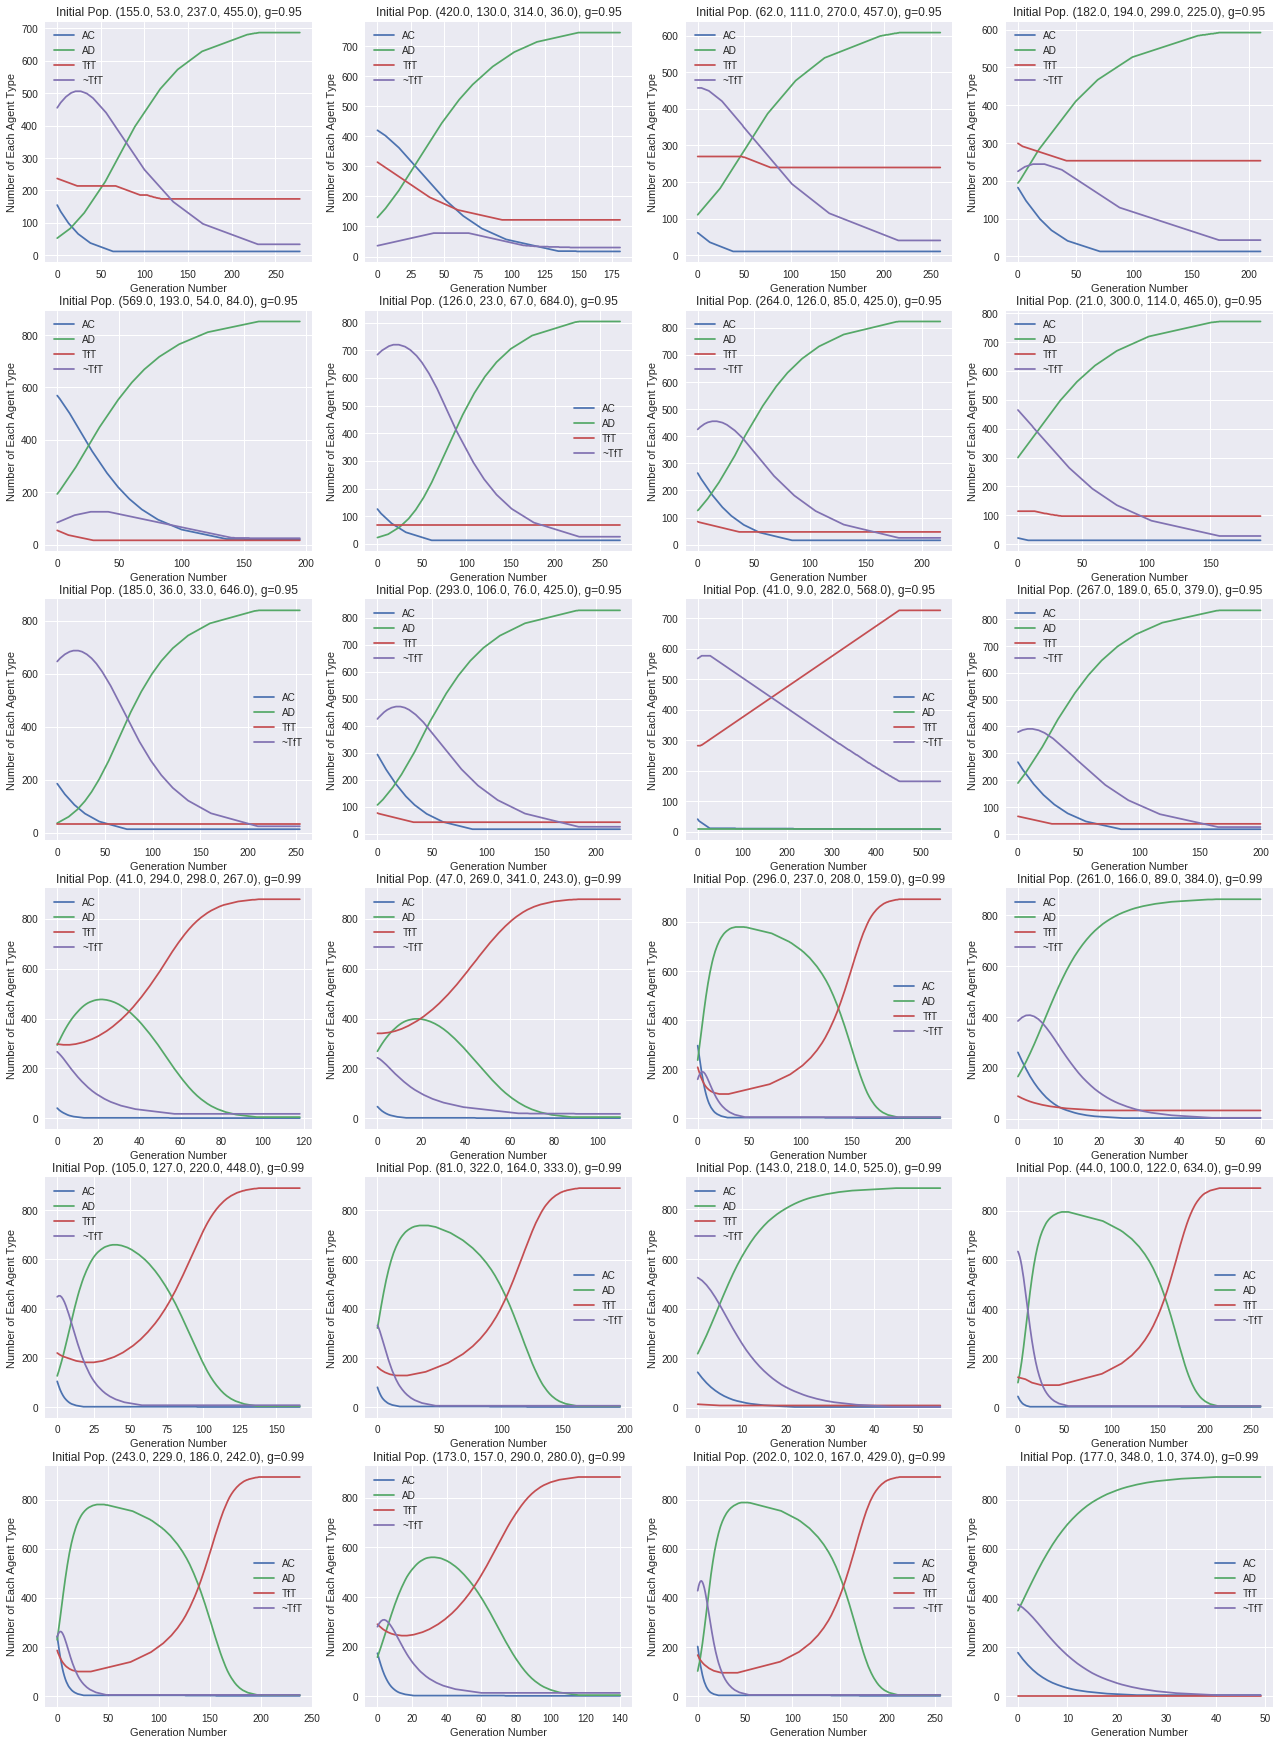

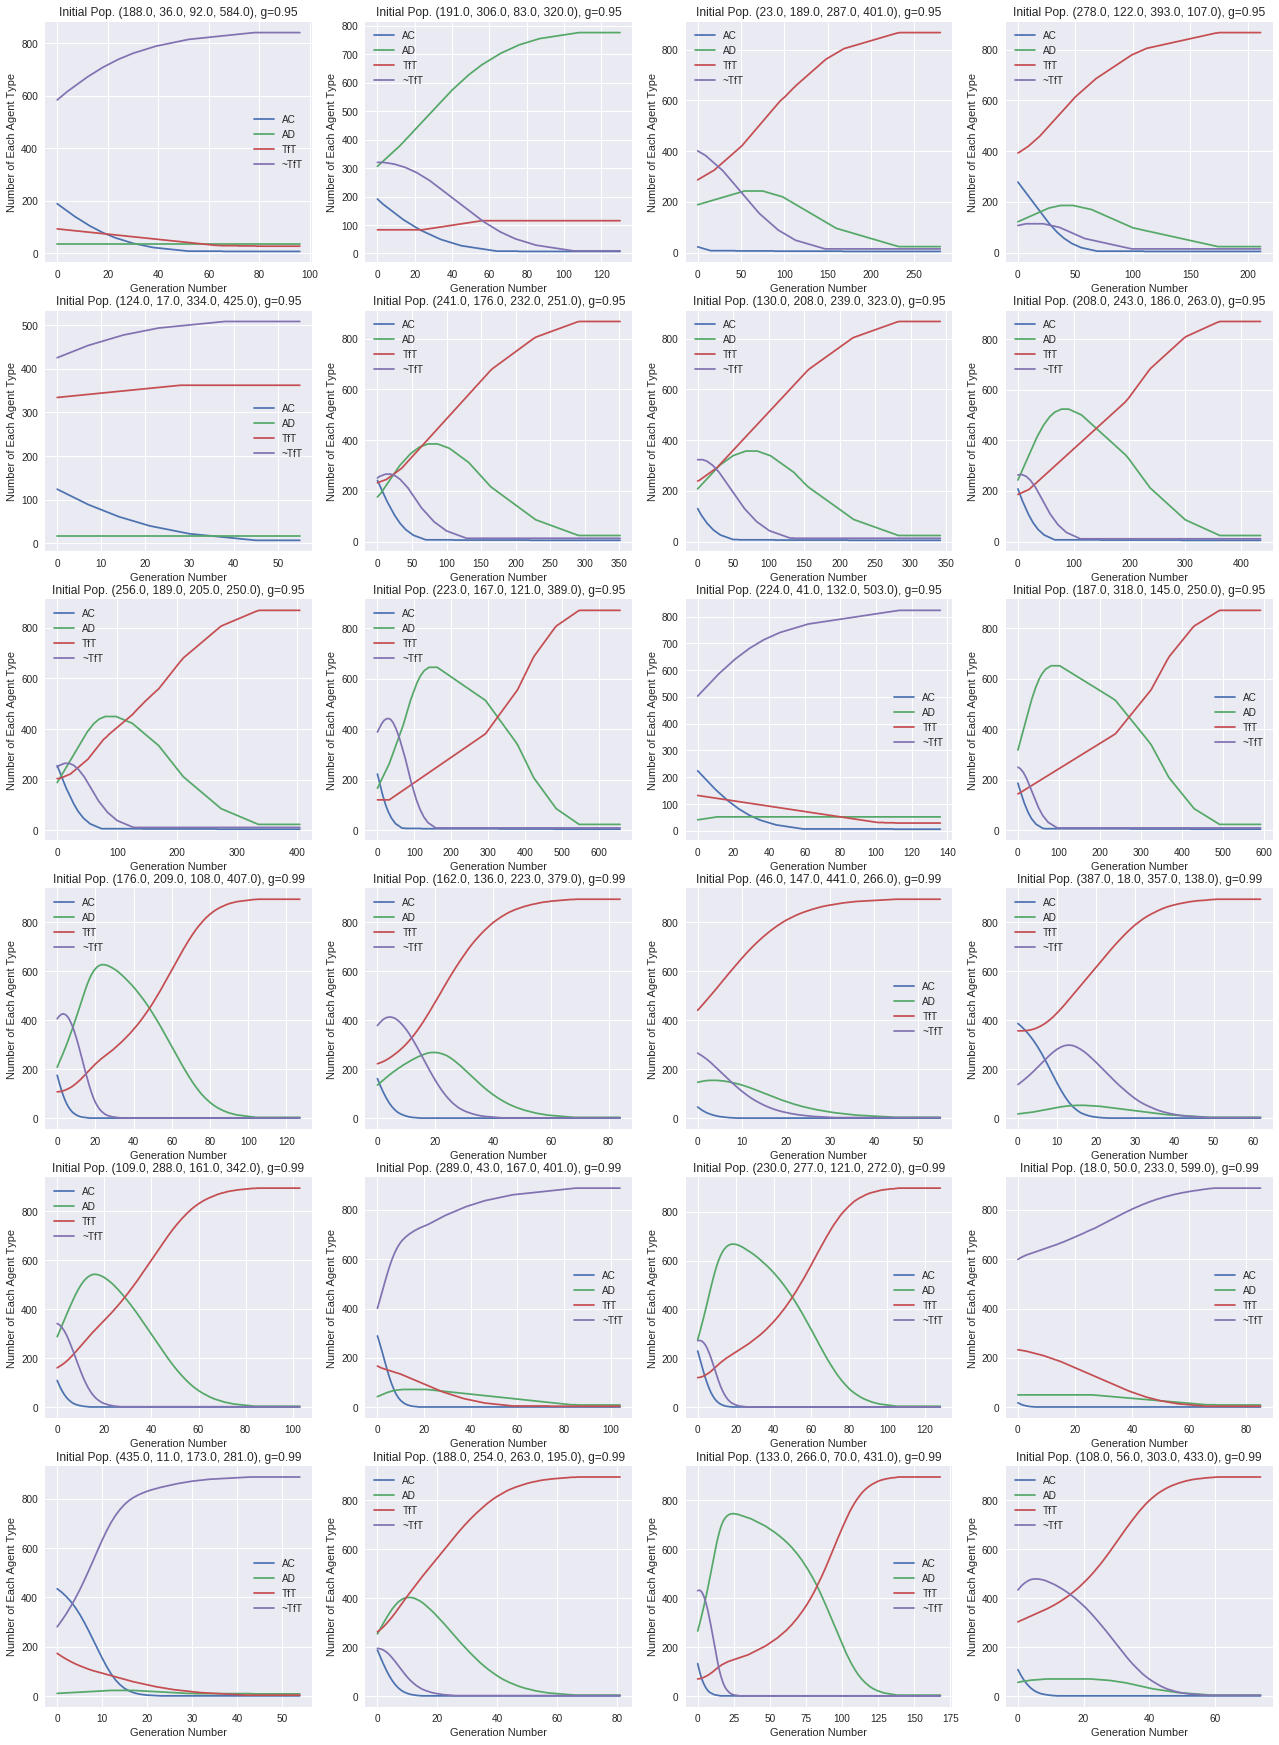

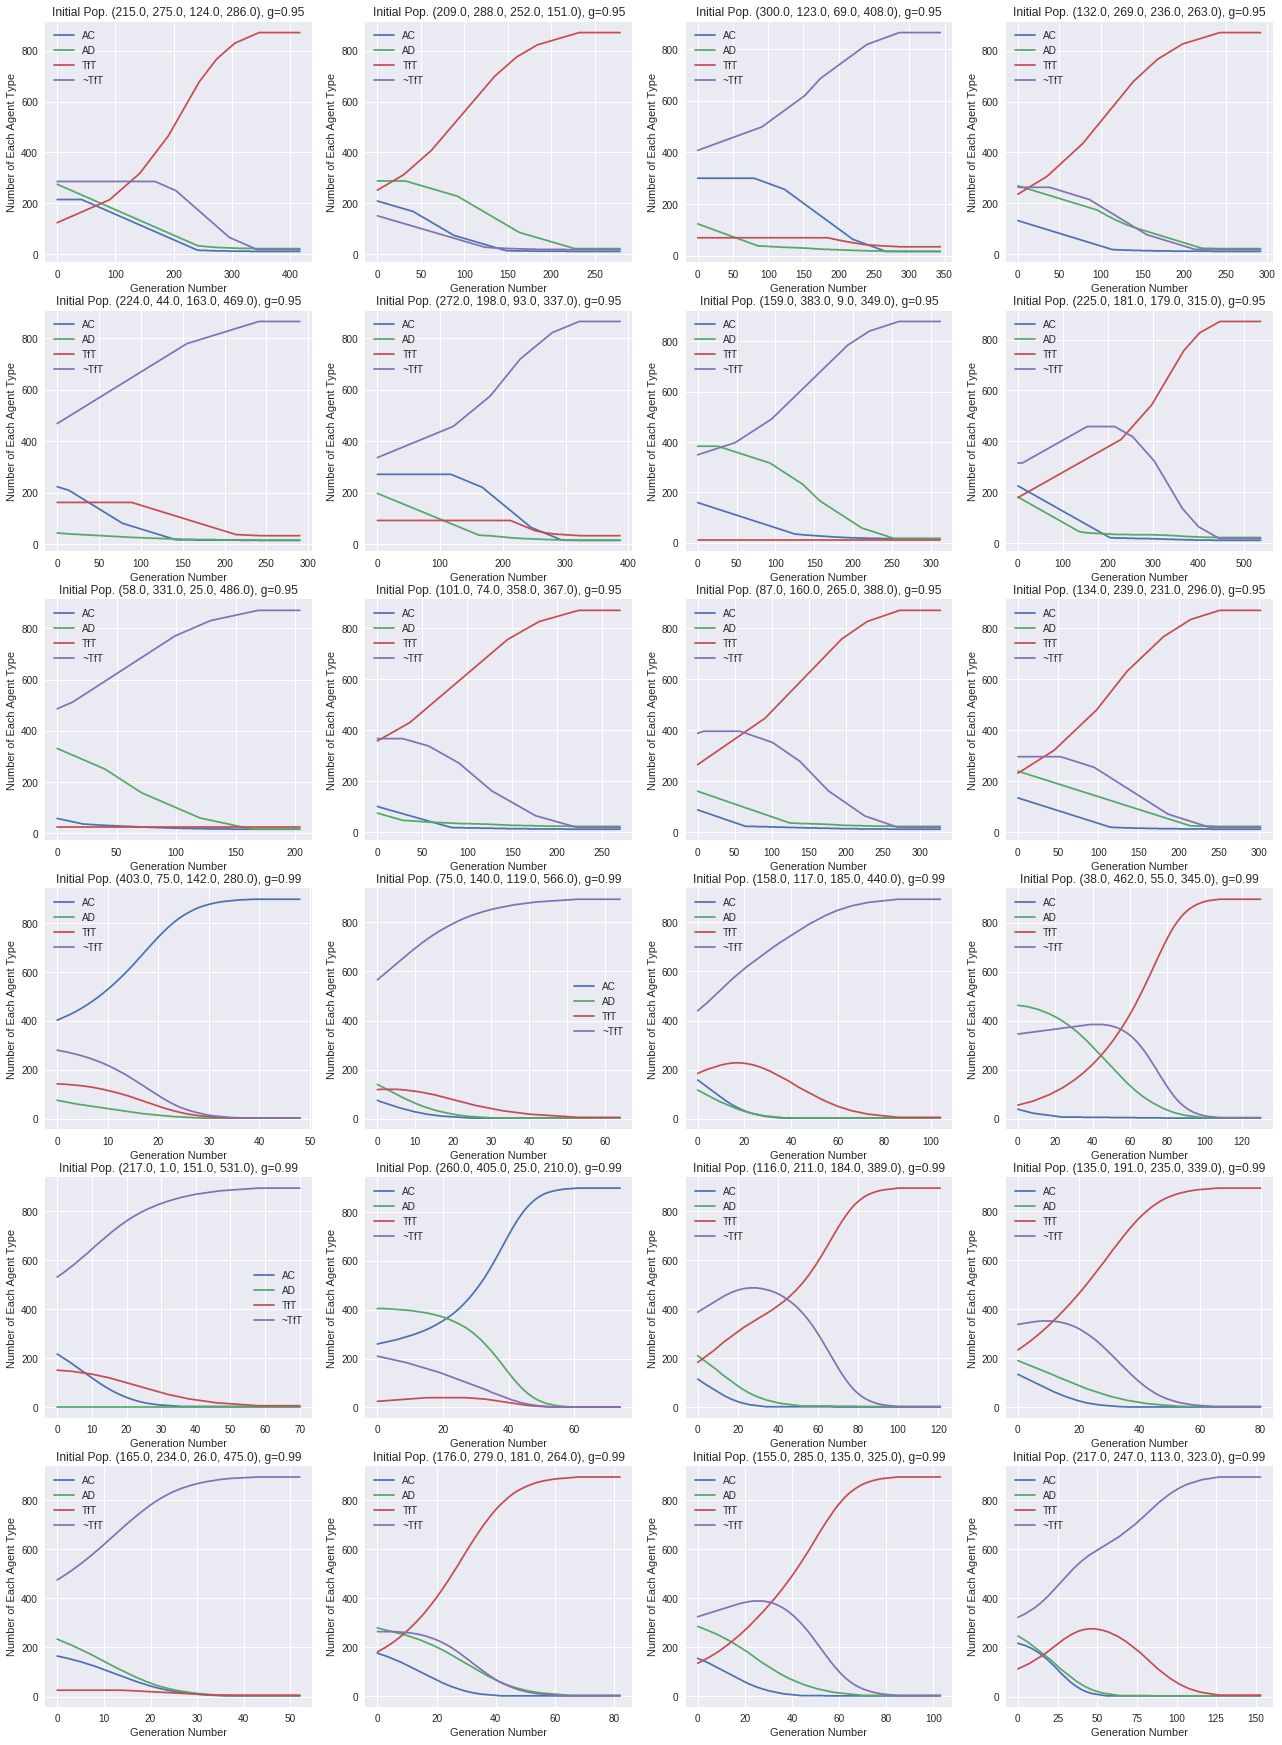

In [0]:
pylab.rcParams['figure.figsize'] = (22,31)

for game in [PD, SH, BS]:
    fig, axes = plt.subplots(6,4)
    for i in range(6):
        for j in range(4):
            
            initial = np.random.rand(5)
            initial = np.round(900*initial/np.sum(initial),0)
            initial[0] = 0
            initial[-1] = 900 - np.sum(initial[:-1])
            
            if i < 3: 
                gamma=0.95 
            else: 
                gamma=0.99
            play_random(initial, gamma, game, ax=axes[i][j])
    
    #fig.suptitle("Random Experiments for the "+game['name'])
    fig.show()

# Setup for lattice experiments

## Construct the neighbor indices matrix

In [0]:
def get_neighbors(n):
    """
    Get an n^2 by n^2 matrix with the neighbor index locations to (i,j) indices 
    in an n x n matrix.
    """
    N = np.zeros((n**2,n**2),dtype=np.int)
    idx_matrix = np.arange(n**2).reshape((n,n))
    
    offset_idx = np.indices((3,) * 2).reshape(2, -1).T
    offsets = np.r_[-1, 0, 1].take(offset_idx)
    offsets = offsets[np.any(offsets, 1)] # Don't count yourself as a neighbor
    
    for i in range(n):
        for j in range(n):
            
            # Get indices for valid neighbors based on offsets
            neighbors = (i,j) + offsets
            valid = np.all((neighbors < (n,n)) & (neighbors >= 0), axis=1)
            neighbors = neighbors[valid]
            
            # Fetch the correct rows in the neighbor location matrix
            N[n*i+j,idx_matrix[neighbors[:,0], neighbors[:,1]]] = 1
            
    return N

## Lattice updating step

In [0]:
def update_lattice(A, N, n, payoffs, num_neighbors, neighbor_locs):
    """
    Update the number of each type of agent in the population based on lattice
    imitator dynamics with lattice pairings.
    
    Arguments
    ---------
    A is the (flattened) n x n matrix of agent types (ints from 1 to 4)
    payoffs[i,j] is the payoff for an i-agent playing against a j-agent
    
    N is a n^2 x n^2 matrix with the agent types of all neighbors
    neighbor_locs is a n^2 x n^2 boolean matrix of where the neighbors are
    num_neighbors is a convenience vector telling us how many neighbors we have
    """
    
    # Everybody plays all their neighbors and we tally results
    average_payoffs = np.zeros(n**2)
    for i in range(n**2):
        my_payoffs = payoffs[A[i],N[i,:]]
        average_payoffs[i] = np.sum(my_payoffs)/num_neighbors[i]
    
    # Broadcast the results across the big neighbor matrix
    N_payoffs = neighbor_locs*average_payoffs
    
    # If your payoff is worse than the best your neighbors did, copy them
    best_payoffs = np.max(N_payoffs,axis=1)
    winners = A[np.argmax(N_payoffs,axis=1)]
    new_A = np.copy(A)
    for i in range(n**2):
        if average_payoffs[i] < best_payoffs[i]:
            new_A[i] = winners[i]
    
    # Choose the neighbor with the best action and broadcast choices
    N = neighbor_locs*new_A
    return new_A, N

## Play a lattice game

In [0]:
def play_lattice(initial_population, gamma, game, num_neighbors, neighbor_locs,
                num_rows=2, num_cols=5):
    
    n = initial_population.shape[0]
    A = initial_population.ravel()
    N = neighbor_locs*A
    results = [A]
    results_set = {tuple(A)}
    payoffs = game['p1_'+str(gamma)]
    
    while True:
        A, N = update_lattice(A, N, n, payoffs, num_neighbors, neighbor_locs)
        results.append(A)
        results_set.add(tuple(A.ravel()))
        if len(results) > len(results_set):
            break
    
    i = 0
    while len(results) < num_rows*num_cols:
        print("You asked for too many rows and columns, I will fix it for you")
        if i % 3 == 0:
            num_rows = max(1,num_rows-1)
        else:
            num_cols = max(2,num_cols-1)
        i += 1
        
    pylab.rcParams['figure.figsize'] = (num_cols*2.5+0.5, num_rows*2.5+num_rows**0.9)
    fig, axes = plt.subplots(num_rows,num_cols)
    vals = np.linspace(-1.75,1.75,num_rows*num_cols)
    scaled = 0.5*len(results)*(1+np.tanh(vals))
    scaled -= np.min(scaled)
    inds = np.round(scaled,0)
    inds[0] = 0
    inds[-1] = len(results)-1
    
    titles = {0:'Initial Population', num_rows*num_cols-1:'Final Population'}
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    my_cmap = matplotlib.colors.ListedColormap(colors[:4])
    kwargs = {'vmin':1,'vmax':4, 'cmap':my_cmap, 'cbar':False,
              'linecolor':'gray','linewidth':0.005,'square':True}
    
    for k in range(len(inds)):
        
        if num_rows > 1:
            ax = axes[int(k/num_cols)][k % num_cols]
        else:
            ax = axes[k]
        seaborn.heatmap(results[int(inds[k])].reshape((n,n)), ax=ax, **kwargs)
        
        if k in titles:
            ax.set_title(titles[k])
        else:
            ax.set_title("Generation "+str(int(inds[k])))
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.suptitle("Population Distribution Over Time for the "+game['name']+
                 ", g="+str(gamma)+" ("+str(len(results))+" Generations)")
    plt.show()

# This only needs to be done ONCE across all experiments
n = 30
neighbor_locs = get_neighbors(n)
num_neighbors = np.count_nonzero(neighbor_locs,axis=1)

# Lattice experiments

Remember, `1:'AD', 2:'AC', 3:'TfT', 4:'~TfT'}`

## Equal-ish regions, everybody touching everybody else

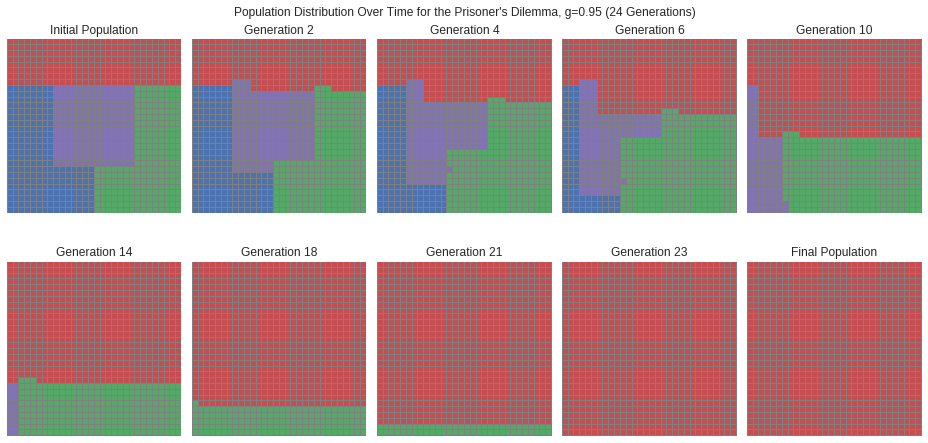

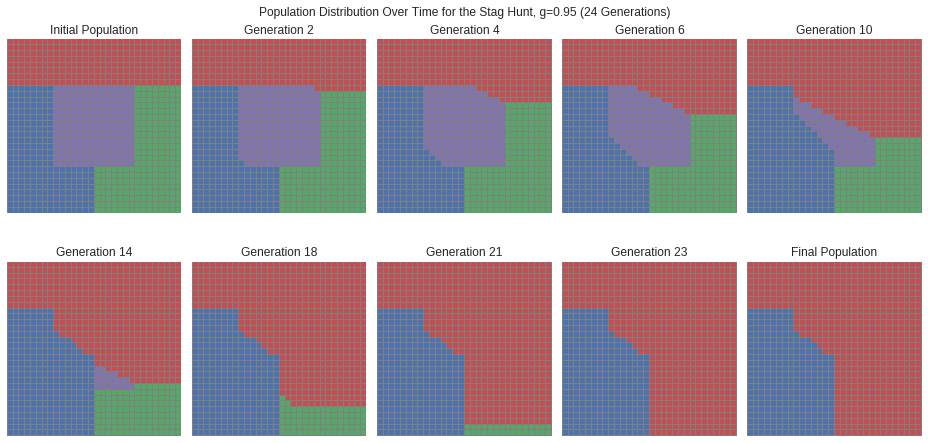

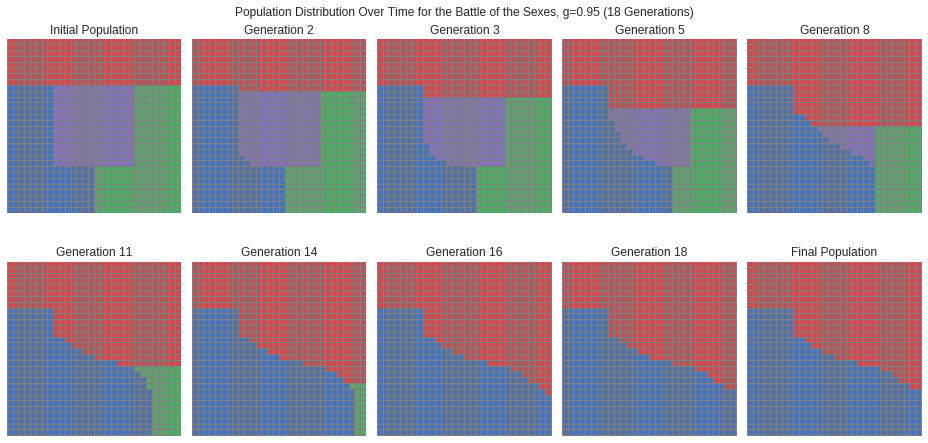

In [0]:
for game in [PD,SH,BS]:
    gamma = 0.95 # Different gamma doesn't make a difference
    #for gamma in [0.95,0.99]:
    A = np.ones((n,n), dtype=np.int)
    A[:,15:] = 2
    A[:8,:] = 3
    A[8:22,8:22] = 4

    play_lattice(A, gamma, game, num_neighbors, neighbor_locs, num_cols=5)

## Wall of TfT protecting AC against the AD-ers

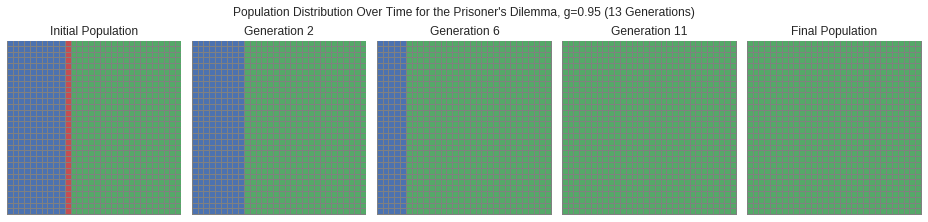

In [0]:
for game in [PD]:#,SH,BS]:
        
    A = np.ones((n,n), dtype=np.int)

    A[:,10:] = 2
    A[:,10:11] = 3
    #A[14,:] = 3

    play_lattice(A, 0.95, game, num_neighbors, neighbor_locs, num_rows=1, num_cols=5)

## Leaky wall of TfT protecting AC against AD-ers

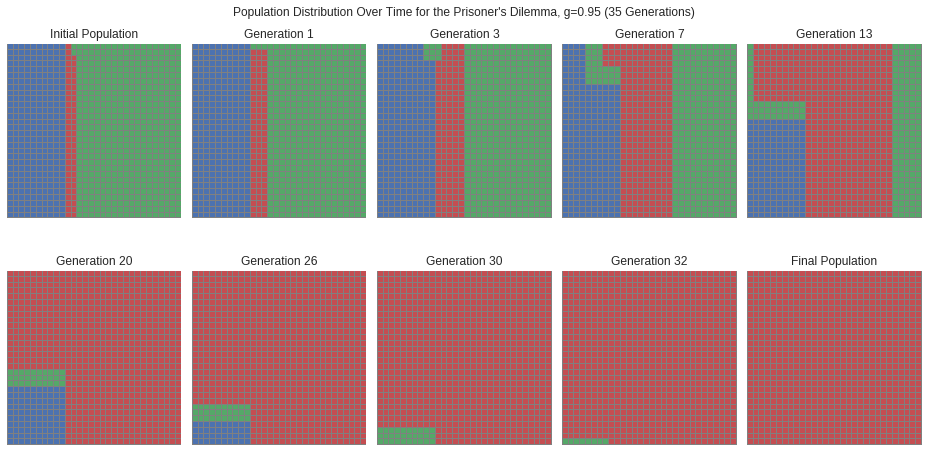

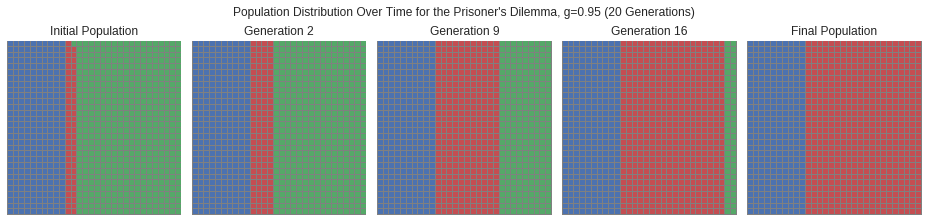

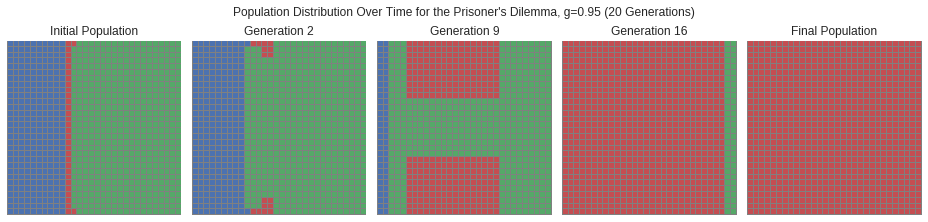

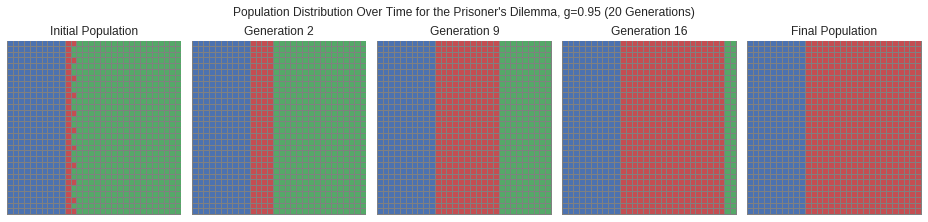

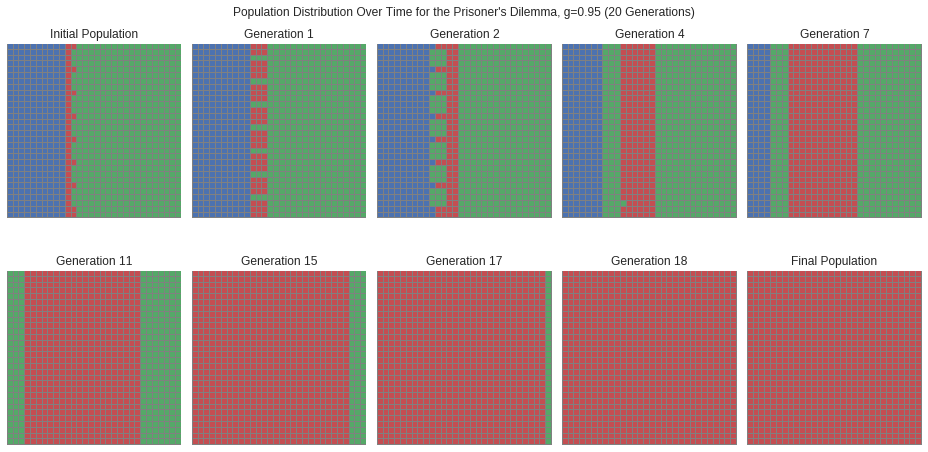

In [0]:
A = np.ones((n,n), dtype=np.int)
A[:,10:] = 2
A[:,10] = 3
A[2:,11] = 3

play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=2, 
             num_cols=5)
A[1,11] = 3
play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1, 
             num_cols=5)
A[:,11] = 3
A[1:-1,11] = 2
play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1,
             num_cols=5)
A[:-1:3,11] = 3
play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1, 
             num_cols=5)
A[1:-1,11] = 2
A[:-1:4,11] = 3
play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=2, 
             num_cols=5)

## Diagonals 

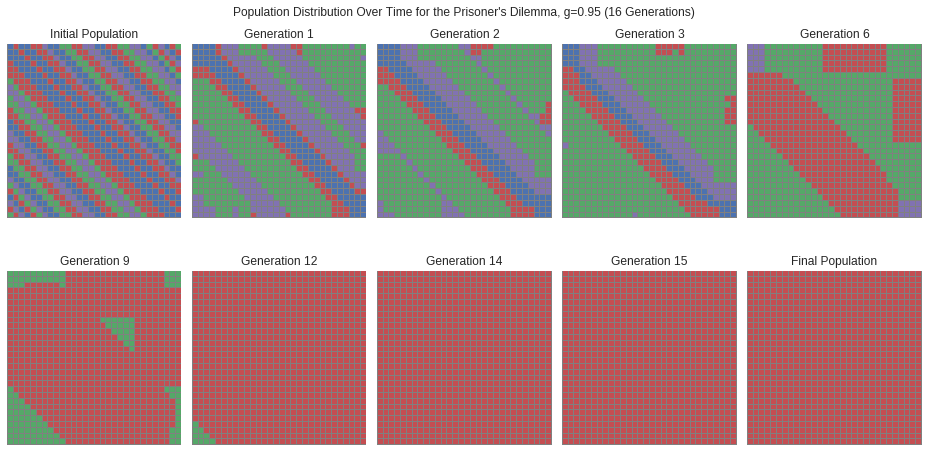

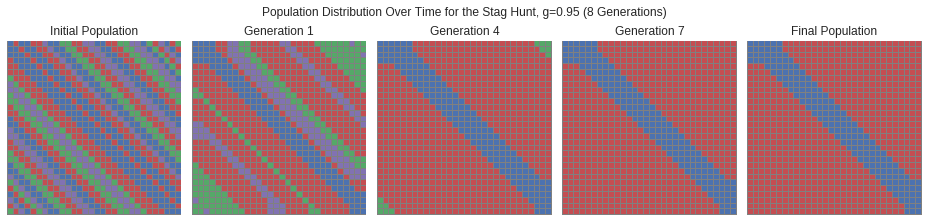

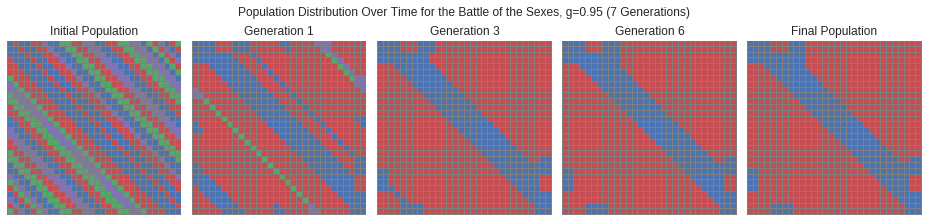

In [0]:
raw = [1,2,3,4,1,3,2,4]
pattern = np.zeros(61)
pattern[:8] = raw
pattern[-8:] = raw
pattern[24:-24] = [2,3,3,3,1,1,1,3,1,1,3,3,4]
pattern[8:24:2] = raw
pattern[9:25:2] = raw
pattern[-24:-8:2] = raw
pattern[-23:-7:2] = raw
A = np.zeros((n,n),dtype=np.int)
for offset in range(-30,31):
    A += np.diag(pattern[offset+30]*np.ones(30-abs(offset)), offset).astype(int)

play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=2, num_cols=5)
play_lattice(np.copy(A), 0.95, SH, num_neighbors, neighbor_locs, num_rows=1, num_cols=5)
play_lattice(np.copy(A), 0.95, BS, num_neighbors, neighbor_locs, num_rows=1, num_cols=5)

## Solitary AD agents in all AC

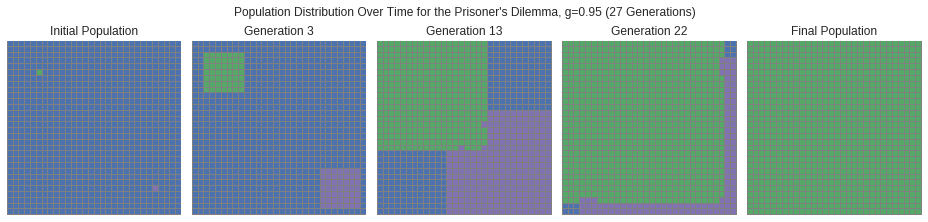

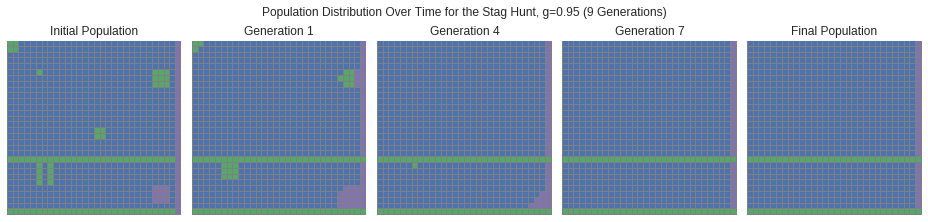

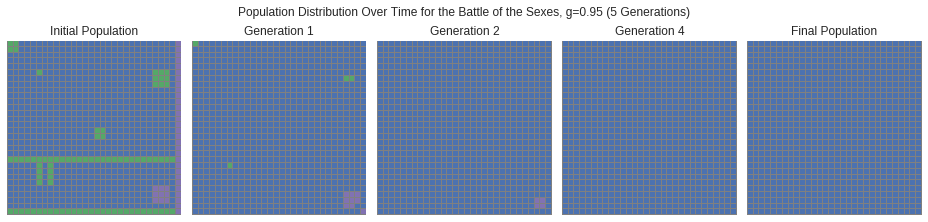

In [0]:
A = np.ones((n,n), dtype=np.int)
A[5,5] = 2
A[25,25] = 4
play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1,
             num_cols=5)
A[15:17,15:17] = 2
A[25:28,25:28] = 4
A[5:8,25:28] = 2
A[0:2,0:2] = 2
A[-1,:] = 2
A[20,:] = 2
A[21:25,5] = 2
A[21:25,7] = 2
A[:,-1] = 4
play_lattice(np.copy(A), 0.95, SH, num_neighbors, neighbor_locs, num_rows=1,
             num_cols=5)
play_lattice(np.copy(A), 0.95, BS, num_neighbors, neighbor_locs, num_rows=1,
             num_cols=5)

## Single solitary TfT or tiny patch in field of AD/~TfT

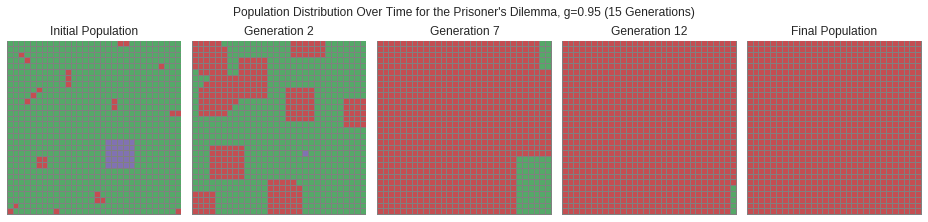

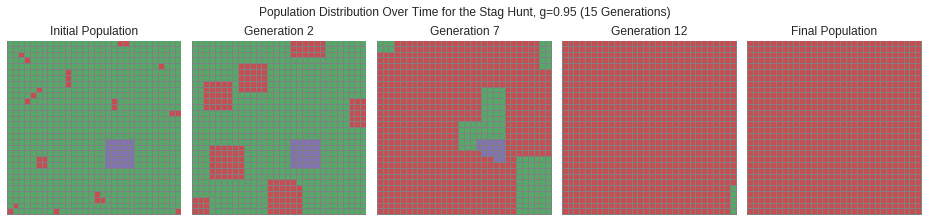

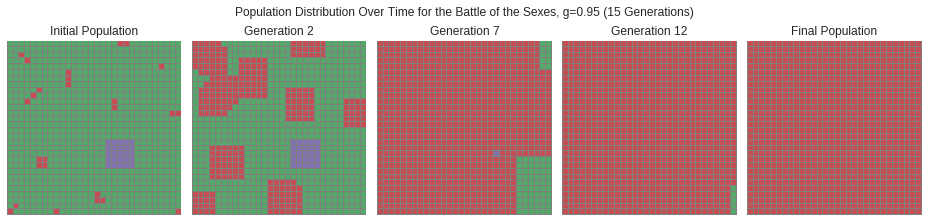

In [0]:
A = 2*np.ones((n,n), dtype=np.int)
A[2,2] = 3
A[3,3] = 3
A[20:22,5:7] = 3
A[5:8,10] = 3
A[4,26] = 3
A[10:12,18] = 3
A[26:28,15] = 3
A[27,16] = 3
A[17:22,17:22] = 4
A[-1,8] = 3
A[0,19:21] = 3
A[12,-2:] = 3
A[-1,-1] = 3
A[-1,0] = 3
A[-2,1] = 3
A[[8,9,10],[5,4,3]] = 3

for game in [PD,SH,BS]:
    play_lattice(np.copy(A), 0.95, game, num_neighbors, neighbor_locs, num_rows=1, num_cols=5)

## Random

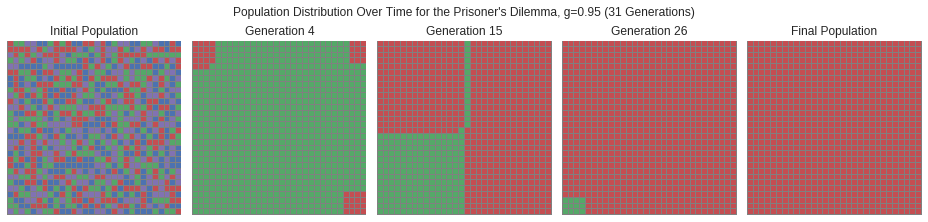

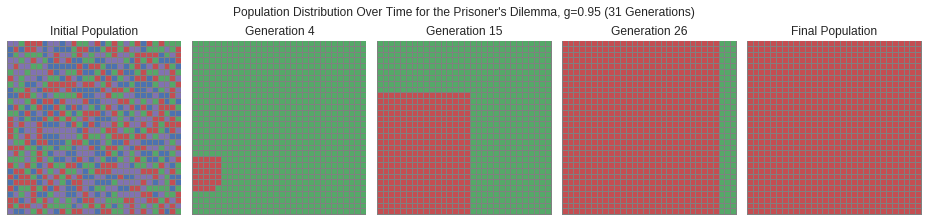

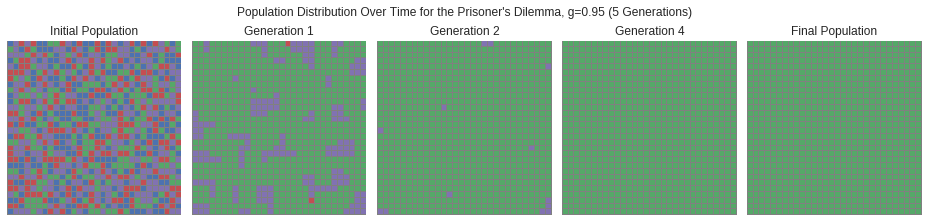

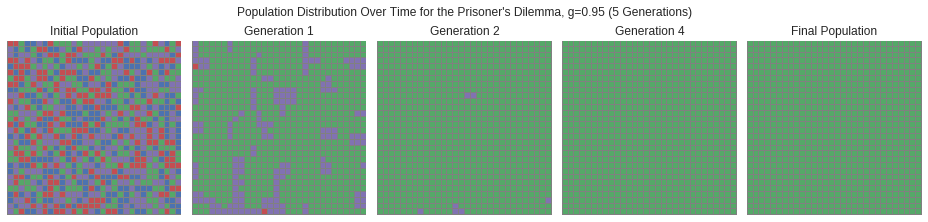

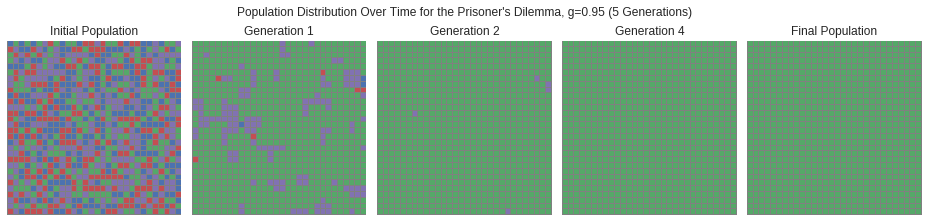

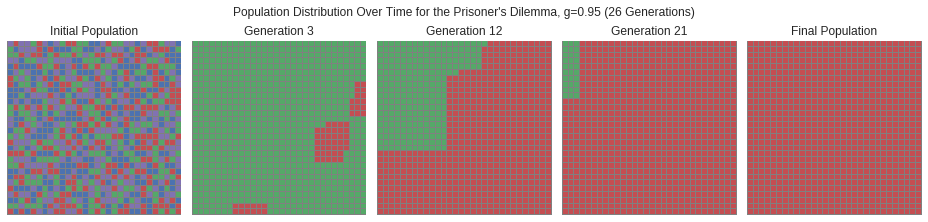

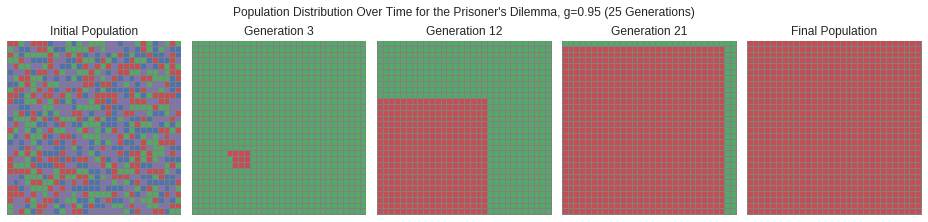

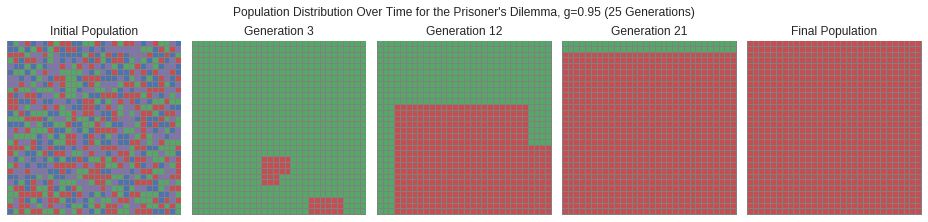

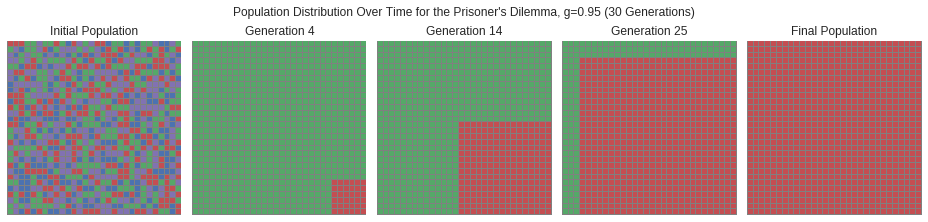

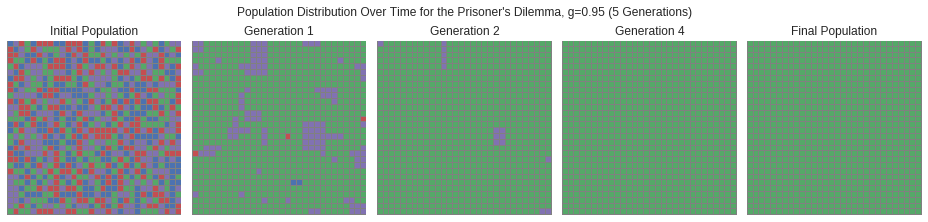

In [0]:
for i in range(10):
    A = np.random.randint(1,5,(30,30),dtype=np.int)
    play_lattice(np.copy(A), 0.95, PD, num_neighbors,neighbor_locs, num_rows=1)

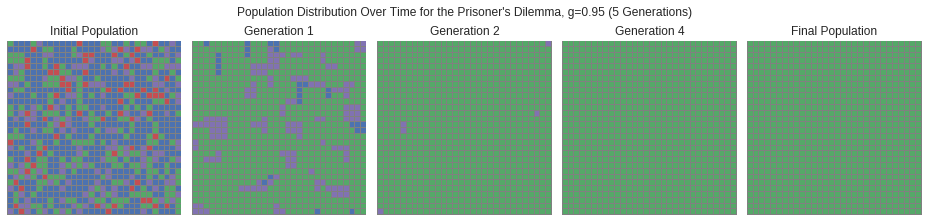

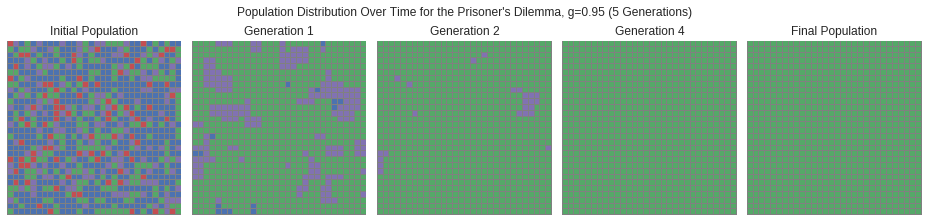

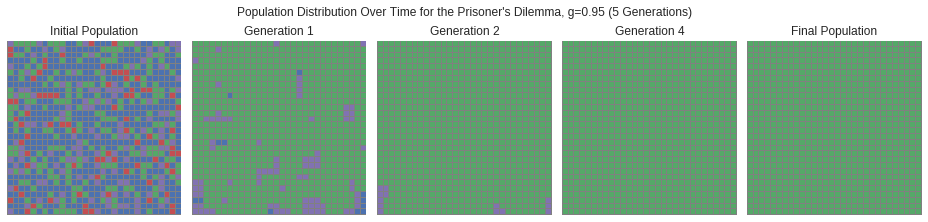

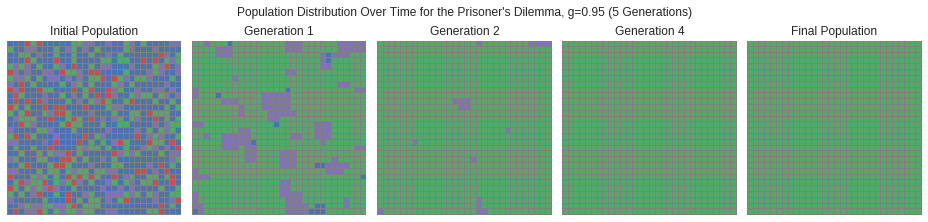

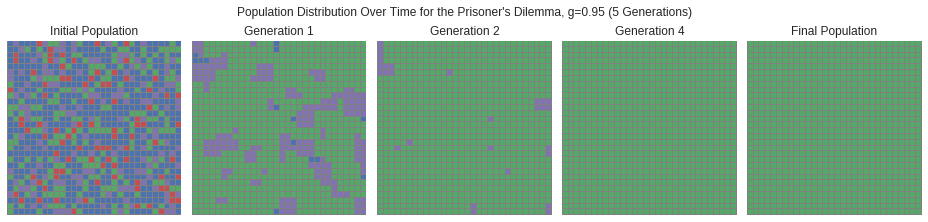

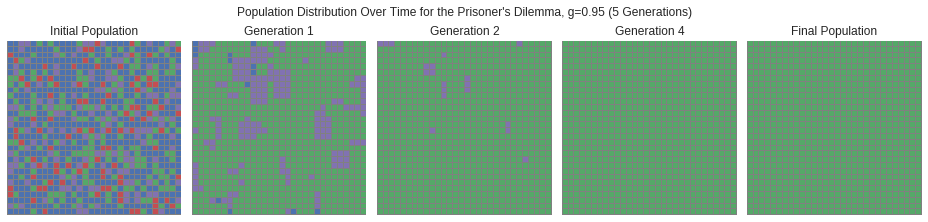

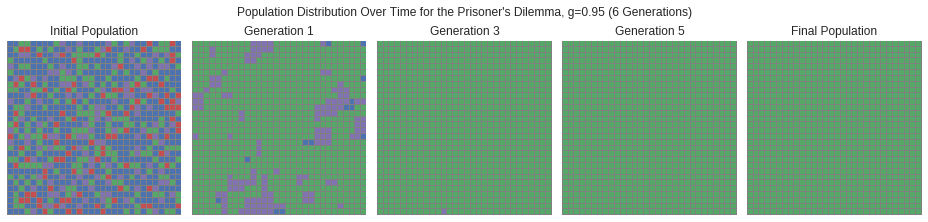

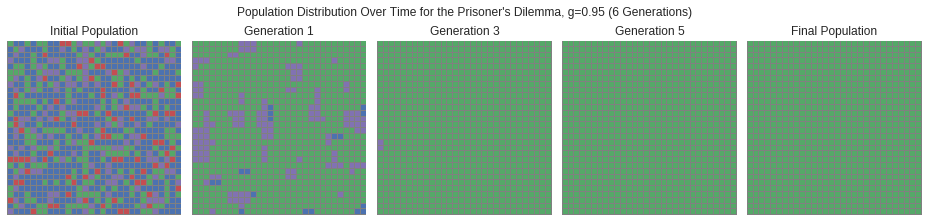

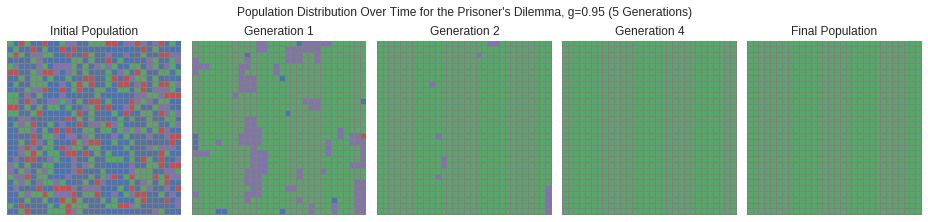

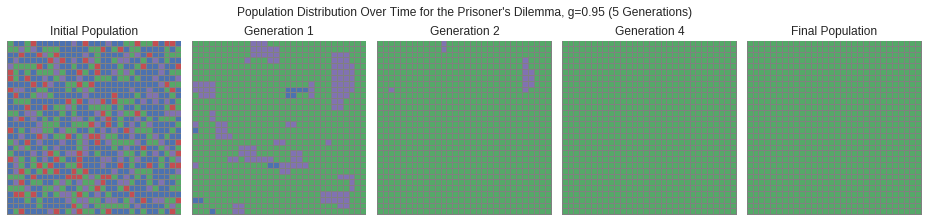

In [0]:
for i in range(10):
    A = np.random.choice([1,2,3,4],size=(30,30),p=[0.5,0.25,0.1,0.15])
    play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1)

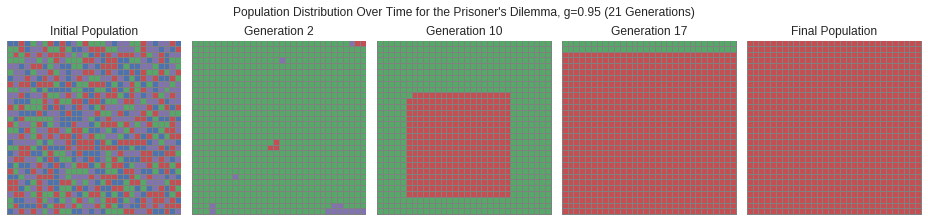

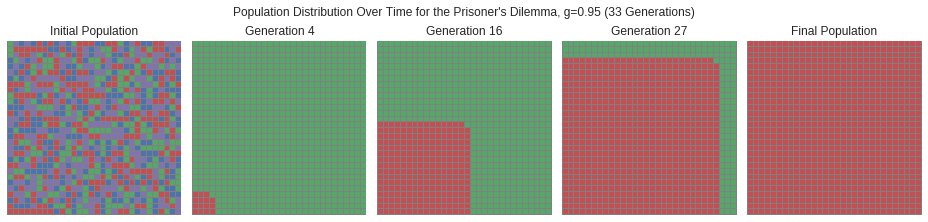

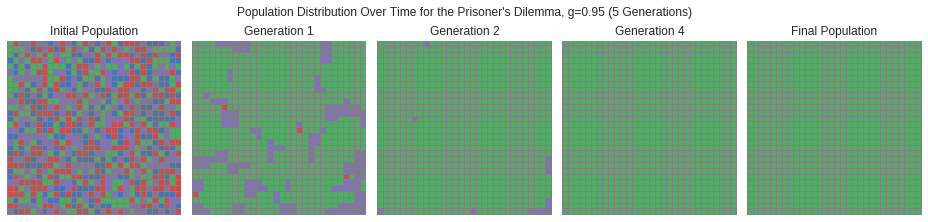

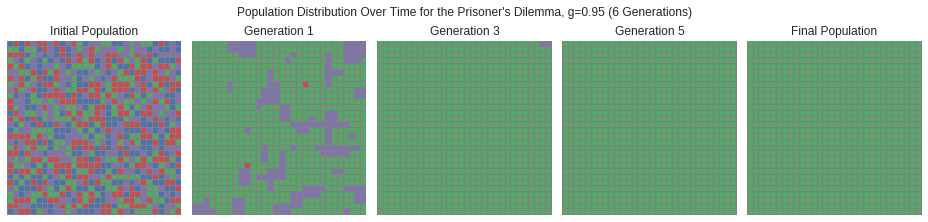

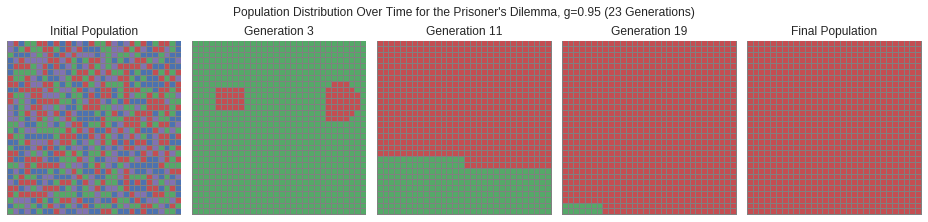

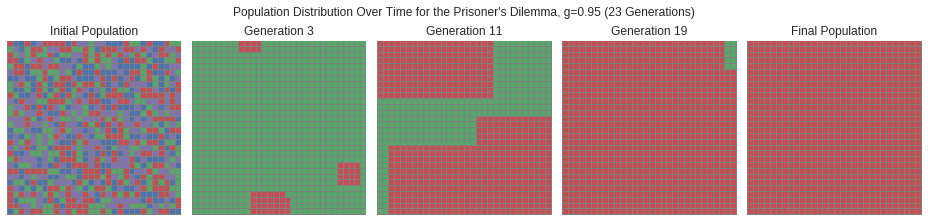

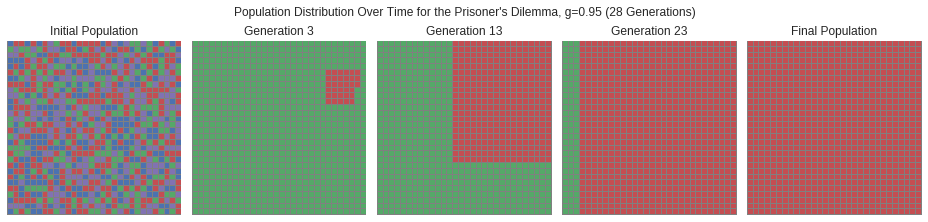

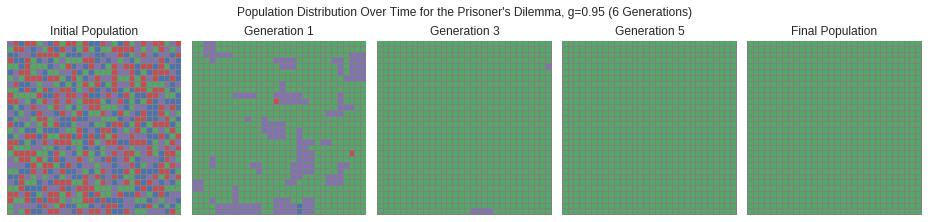

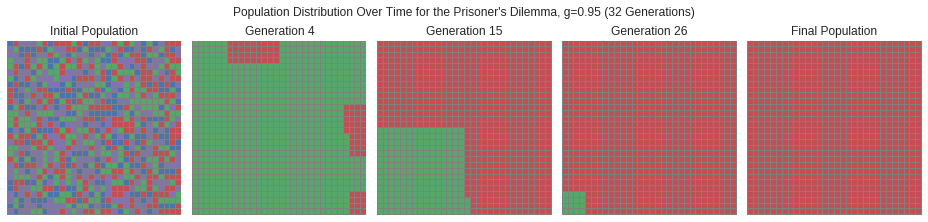

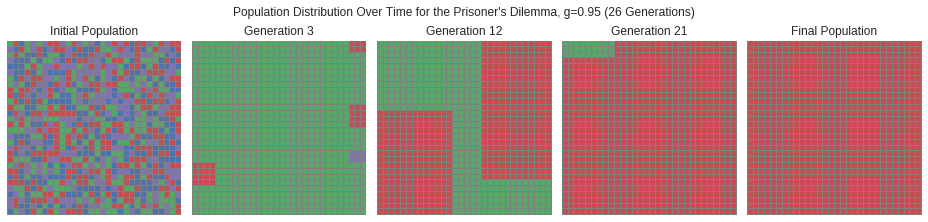

In [0]:
for i in range(10):
    A = np.random.choice([1,2,3,4],size=(30,30),p=[0.24,0.24,0.28,0.24])
    play_lattice(np.copy(A), 0.95, PD, num_neighbors, neighbor_locs, num_rows=1)